# Details of the `beam_size()` Algorithm

**Scott Prahl**

**Sept 2023**

The ISO 11146 standard recommends masking the image with a rotated rectangular mask around the center of the image.  This notebook explains how that was implemented and then shows some results for artifically generated images of non-circular Gaussian beams. As noise increases, the first-order parameters (beam center) are robust, but the second-order parameters (diameters) are shown to be much more sensitive to image noise.

In [1]:
import requests
import io
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import laserbeamsize as lbs

repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/"


def side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi, noise=0, offset=0):
    """Creates plot of original and of fitted beam."""
    test = lbs.create_test_image(h, v, xc, yc, d_major, d_minor, phi, noise=noise)
    xc_found, yc_found, d_major_found, d_minor_found, phi_found = lbs.beam_size(test)

    plt.subplots(1, 2, figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test, cmap="gist_ncar")
    plt.plot(xc, yc, "ob", markersize=2)
    plt.title(
        r"Original (%d,%d), d_major=%.0f, d_minor=%.0f, $\phi$=%.0f°"
        % (xc, yc, d_major, d_minor, np.degrees(phi))
    )

    plt.subplot(1, 2, 2)
    plt.imshow(test, cmap="gist_ncar")
    xp, yp = lbs.rotated_rect_arrays(xc_found, yc_found, d_major_found, d_minor_found, phi_found)
    plt.plot(xp, yp, ":y")
    plt.plot(xc_found, yc_found, "ob", markersize=2)
    plt.title(
        r"Found (%d,%d), d_major=%.0f, d_minor=%.0f, $\phi$=%.0f°"
        % (xc_found, yc_found, d_major_found, d_minor_found, np.degrees(phi_found))
    )

## Integration Area

ISO 11146-3 states::

> All integrations ... are performed on a rectangular integration area which is centred to the beam centroid, defined by the spatial first order moments, orientated parallel to the principal axes of the power density distribution, and sized three times the beam widths $d_{\sigma x}$ and $d_{\sigma y}$...

This turned out to be surprisingly fiddly (most likely because masked numpy arrays did't work as I expected).  In the pictures that follow, the dotted rectangle shows the final integration area.

## Algorithm Overview

This shows the effect of background removal, then rectangle masking, then locating the center and diameter of the beam.  The noise values are low and the background is zeroed out.  This diagram shows two iterations of this process.  In practice, this process is repeated until the diameters remain the same as the previous iteration.

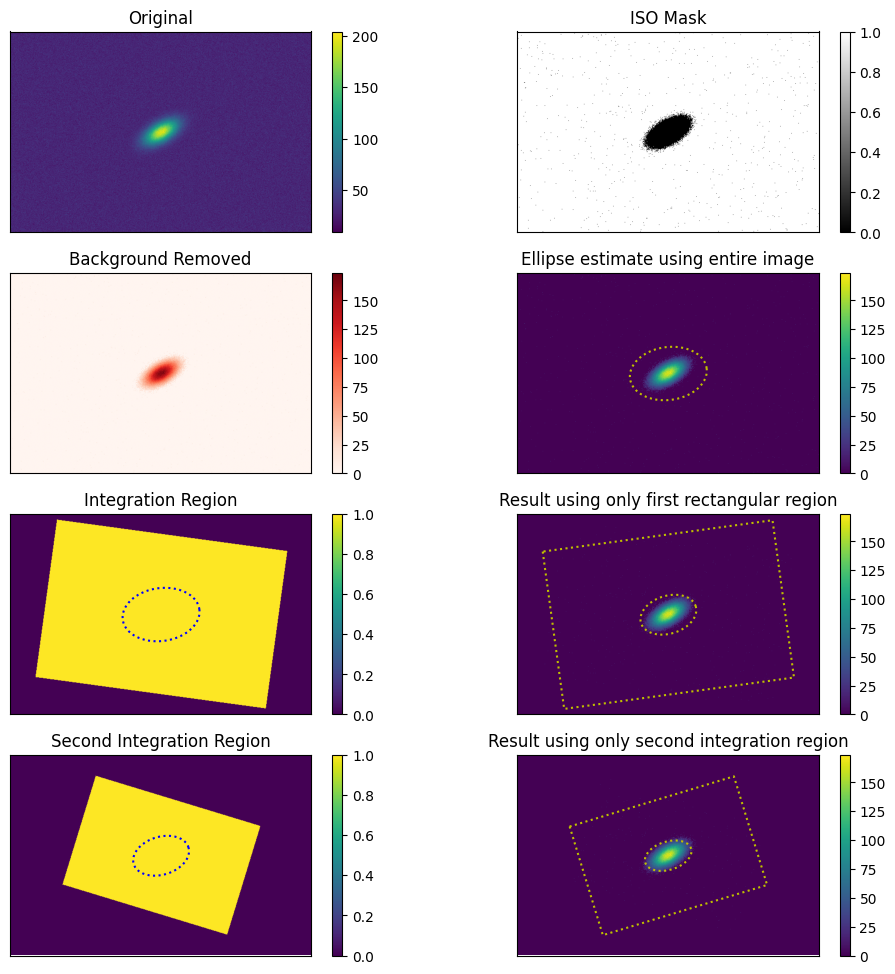

In [2]:
xc, yc, d_major, d_minor, phi = 300, 200, 100, 50, np.radians(30)
h, v = 600, 400
max_value = 1023
noise = 30

# generate test image
test = lbs.create_test_image(h, v, xc, yc, d_major, d_minor, phi, noise=noise)

plt.subplots(4, 2, figsize=(12, 12))
plt.subplot(4, 2, 1)
plt.imshow(test)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title("Original")

# corners
corners = lbs.corner_mask(test)
plt.subplot(4, 2, 2)
plt.imshow(lbs.iso_background_mask(test), cmap="gray")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title("ISO Mask")

# remove background
zeroed = lbs.subtract_iso_background(test, iso_noise=False)

plt.subplot(4, 2, 3)
plt.imshow(zeroed, cmap=lbs.create_plus_minus_cmap(zeroed))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title("Background Removed")

# first guess at beam parameters
xc, yc, d_major, d_minor, phi = lbs.basic_beam_size(zeroed)

plt.subplot(4, 2, 4)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp, yp = lbs.ellipse_arrays(xc, yc, d_major, d_minor, phi)
plt.plot(xp, yp, ":y")
plt.title("Ellipse estimate using entire image")

mask = lbs.rotated_rect_mask(zeroed, xc, yc, d_major, d_minor, phi)

plt.subplot(4, 2, 5)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp, yp = lbs.ellipse_arrays(xc, yc, d_major, d_minor, phi)
plt.plot(xp, yp, ":b")
plt.title("Integration Region")

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0  # zero all values outside mask

# first guess at beam parameters
xc1, yc1, d_major1, d_minor1, phi1 = lbs.basic_beam_size(masked_image)

plt.subplot(4, 2, 6)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp, yp = lbs.rotated_rect_arrays(xc, yc, d_major, d_minor, phi)
plt.plot(xp, yp, ":y")
xp, yp = lbs.ellipse_arrays(xc1, yc1, d_major1, d_minor1, phi1)
plt.plot(xp, yp, ":y")
plt.title("Result using only first rectangular region")

# second pass
mask = lbs.rotated_rect_mask(zeroed, xc1, yc1, d_major1, d_minor1, phi1)

plt.subplot(4, 2, 7)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp, yp = lbs.ellipse_arrays(xc1, yc1, d_major1, d_minor1, phi1)
plt.plot(xp, yp, ":b")
plt.title("Second Integration Region")

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0  # zero all values outside mask

# first guess at beam parameters
xc2, yc2, d_major2, d_minor2, phi2 = lbs.basic_beam_size(masked_image)

plt.subplot(4, 2, 8)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp, yp = lbs.rotated_rect_arrays(xc1, yc1, d_major1, d_minor1, phi1)
plt.plot(xp, yp, ":y")
xp, yp = lbs.ellipse_arrays(xc2, yc2, d_major2, d_minor2, phi1)
plt.plot(xp, yp, ":y")
plt.title("Result using only second integration region")
plt.show()

## Integration Area Tests

### Test 1 Centered, Horizontal, away from edges

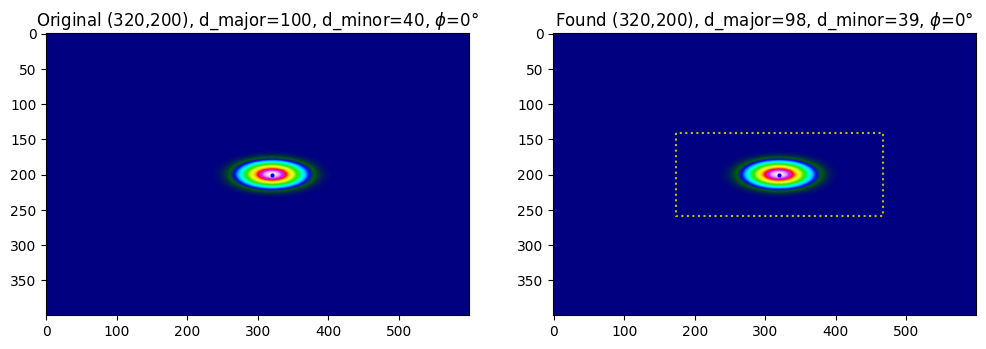

In [3]:
xc = 320
yc = 200
d_major = 100
d_minor = 40
phi = np.radians(0)
h = 600
v = 400

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi)
plt.show()

### Test 2 Corner, Horizontal

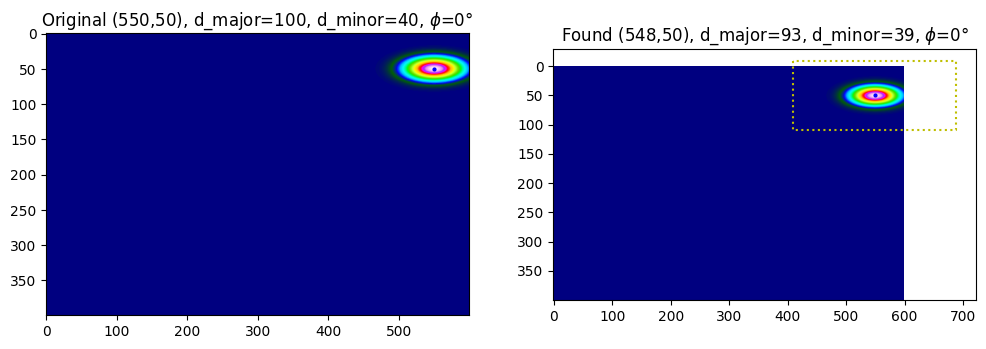

In [4]:
xc = 550
yc = 50

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi)
plt.show()

### Test 3 Center, tilted 30°

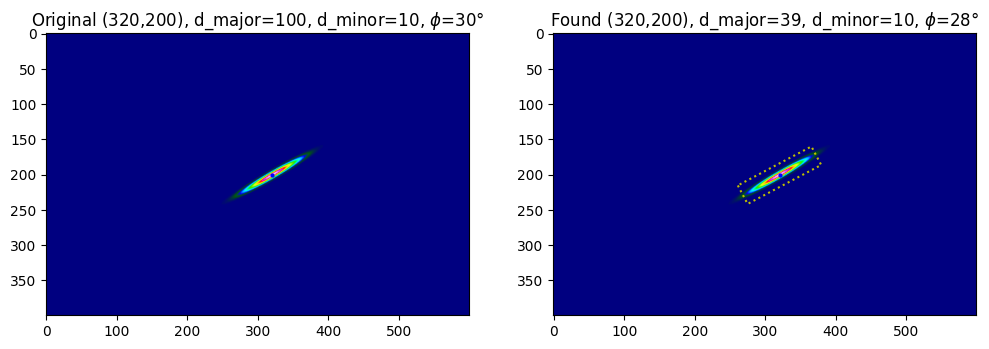

In [5]:
xc = 320
yc = 200
d_major = 100
d_minor = 10
phi = np.radians(30)

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi)
plt.show()

### Test 4 Corner, tilted 30°

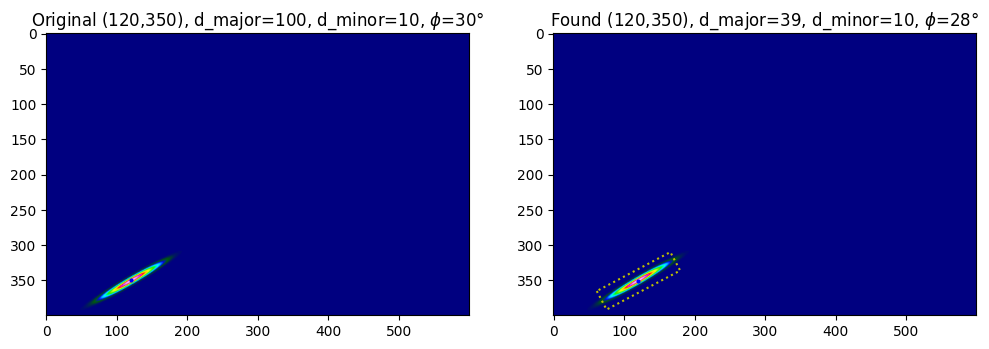

In [6]:
xc = 120
yc = 350

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi)
plt.show()

### Test 5 Center, tilted 70°

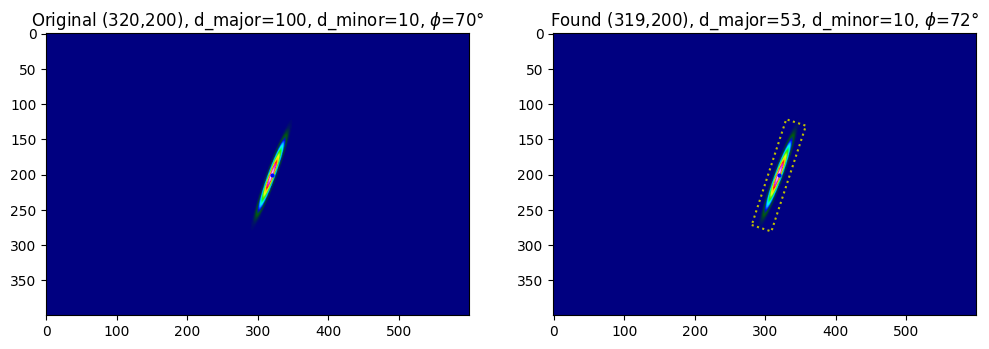

In [7]:
xc = 320
yc = 200
d_major = 100
d_minor = 10
phi = np.radians(70)

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi)
plt.show()

## Tests with Poisson noise

### Test 1. Simple, noise-free rotated elliptical beam

In this and all rest of the test functions, the maximum value in the test array is 256.

No gaussian noise, works fine!

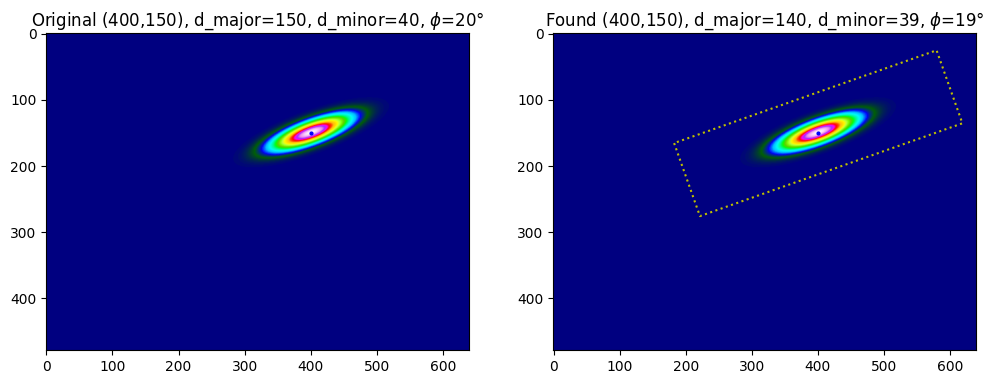

In [8]:
xc = 400
yc = 150
d_major = 150
d_minor = 40
phi = np.radians(20)
h = 640
v = 480

side_by_side_plot(h, v, xc, yc, d_major, d_minor, phi, noise=0)
plt.show()

### Test 2: Rotated elliptical beam with 8% Poisson noise

Here the added noise is low enough that `iso_noise=True` method works fine.

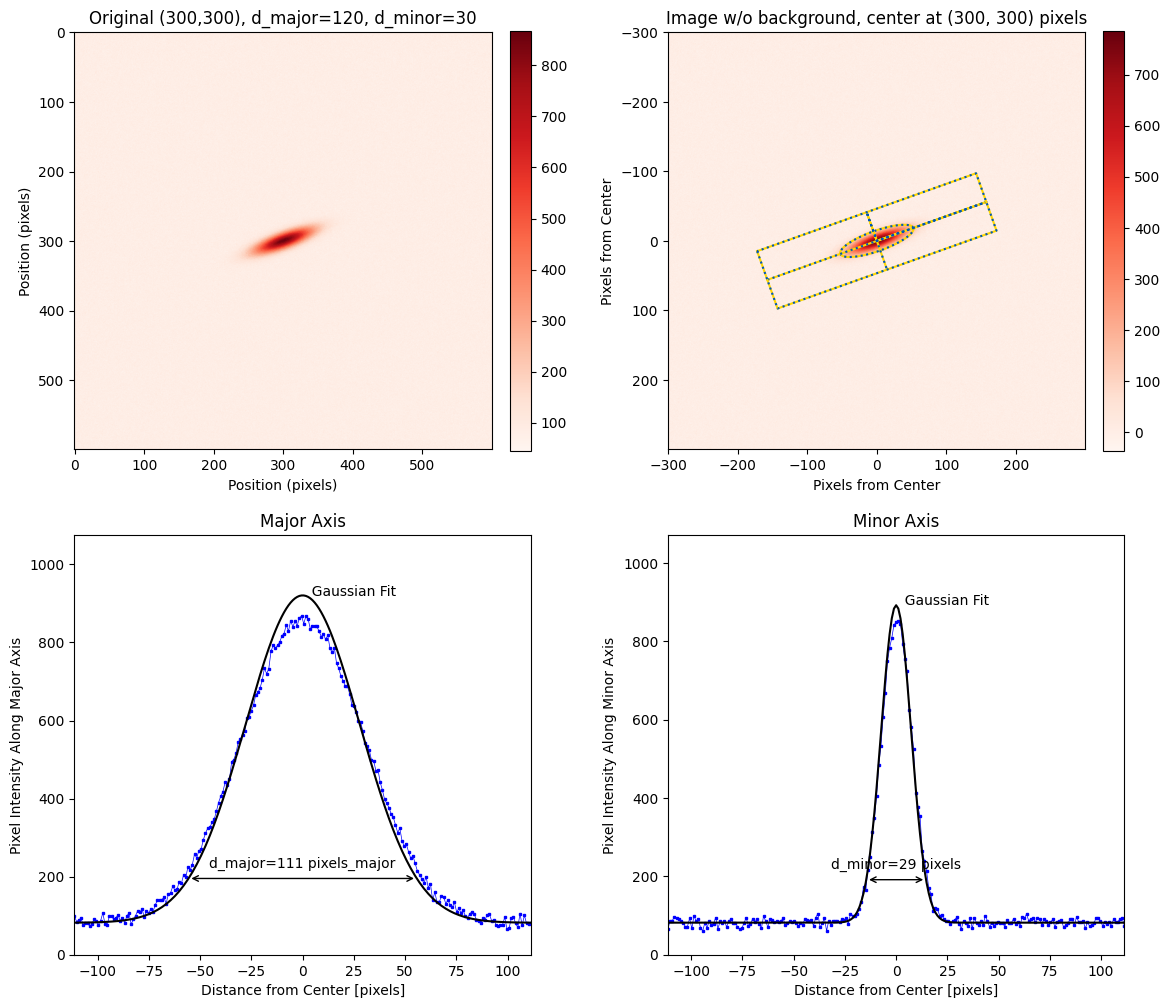

In [9]:
xc, yc, d_major, d_minor, phi = 300, 300, 120, 30, np.radians(20)
h, v = 600, 600
max_value = 1023
noise = 0.08 * max_value

test = lbs.create_test_image(h, v, xc, yc, d_major, d_minor, phi, noise=noise, max_value=max_value)
title = "Original (%d,%d), d_major=%d, d_minor=%d" % (xc, yc, d_major, d_minor)

lbs.plot_image_analysis(test, title, iso_noise=True, cmap=lbs.create_plus_minus_cmap(test))
# plt.savefig('plot2.pdf', bbox_inches = 'tight')
plt.show()

### Test 3: Experimental Image

This is a HeNe beam from a polarized HeNe which should be close to TEM₀₀.

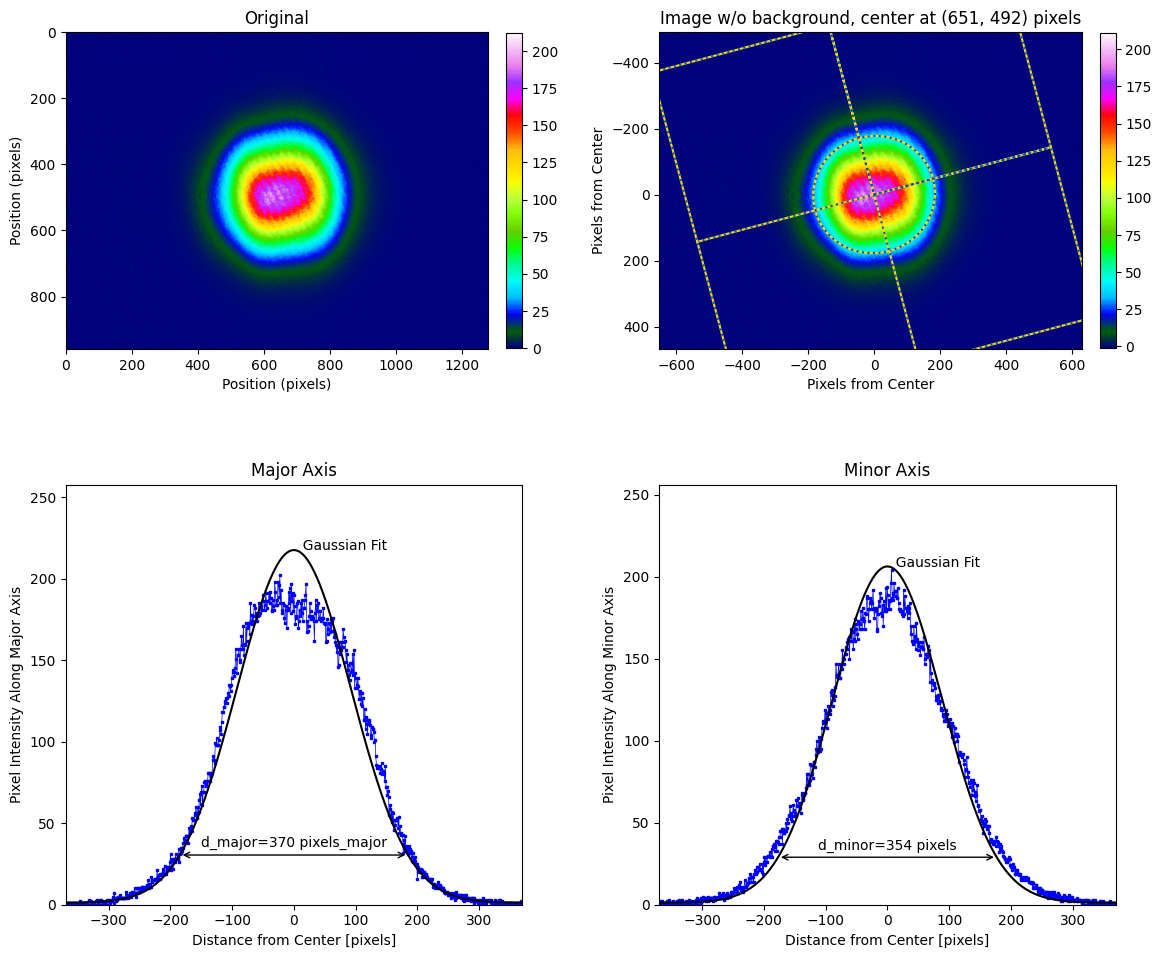

In [10]:
beam = iio.imread(repo + "t-hene.pgm")
lbs.plot_image_analysis(beam, iso_noise=True)
# plt.savefig('hene.png', bbox_inches = 'tight')
plt.show()

### Test 4: Asymmetric Experimental Image

  359.23   270.66   274.57   184.50    90.00°
The corner pixels have an average         17.8 ± 30.0)
The un-illuminated pixels have an average 24.0 ± 28.1)


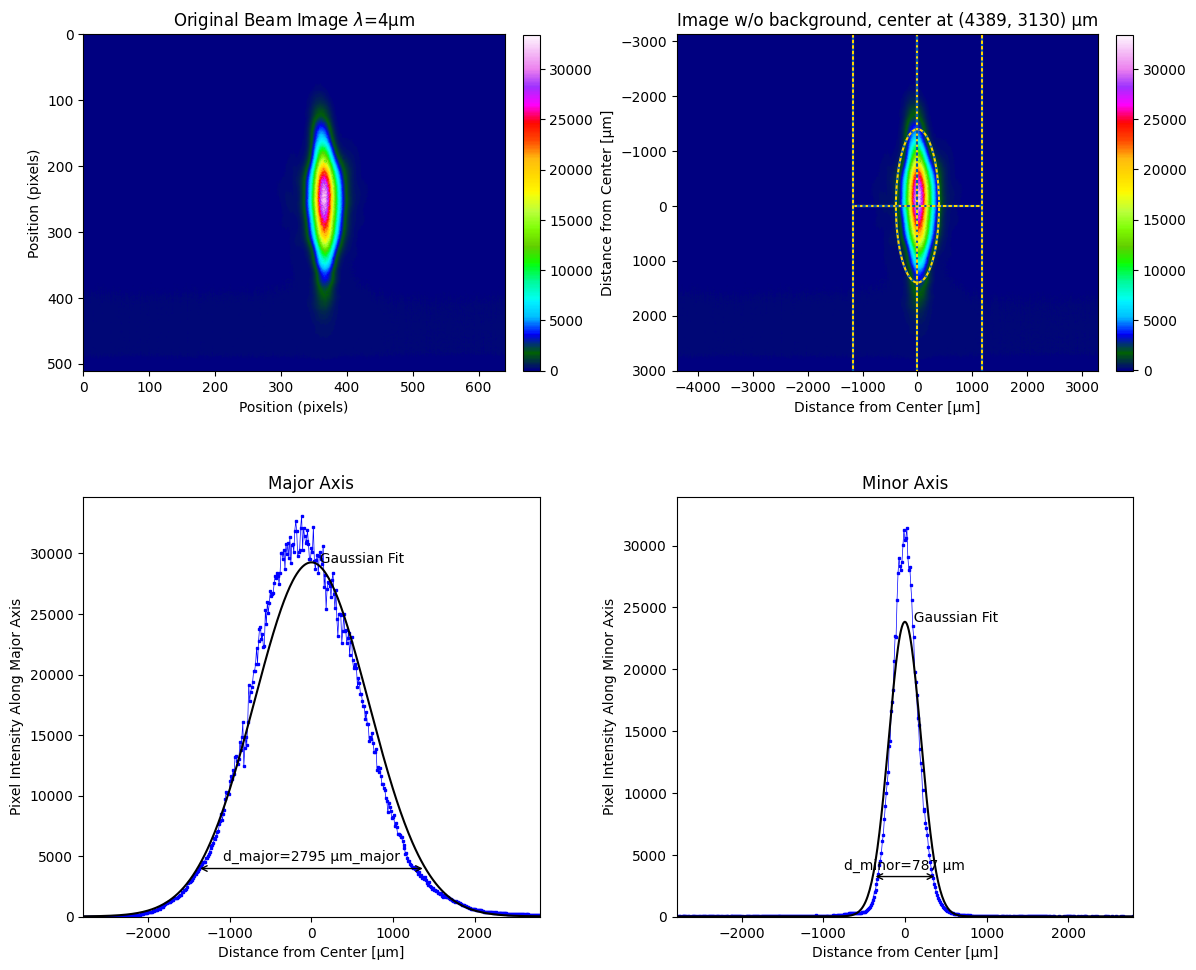

In [11]:
# Image contributed by Werefkin
# Created using an f=750 mm spherical mirror for focusing under 45 degrees incidence
# The pixel size is 12 µm, wavelength is 4 µm (actually it is a polychromatic beam)

response = requests.get(repo + "astigmatic_beam_profile.npy")
response.raise_for_status()
beam = np.load(io.BytesIO(response.content))  # Works!

xc, yc, d_major, d_minor, phi = lbs.basic_beam_size(beam, phi_fixed=np.pi / 2)
print("%8.2f %8.2f %8.2f %8.2f %8.2f°" % (xc, yc, d_major, d_minor, np.degrees(phi)))

mean, stdev = lbs.corner_background(beam)
print("The corner pixels have an average         %.1f ± %.1f)" % (mean, stdev))
mean, stdev = lbs.iso_background(beam)
print("The un-illuminated pixels have an average %.1f ± %.1f)" % (mean, stdev))

# beam = np.load("astigmatic_beam_profile.npy")
lbs.plot_image_analysis(
    beam, r"Original Beam Image $\lambda$=4µm", pixel_size=12, units="µm", iso_noise=True, phi_fixed=np.pi / 2
)
# plt.savefig('astigmatic_beam_profile.png', bbox_inches = 'tight')
plt.show()

### Test 5: Verify that `plot_image_analysis()` properly identifies major axis

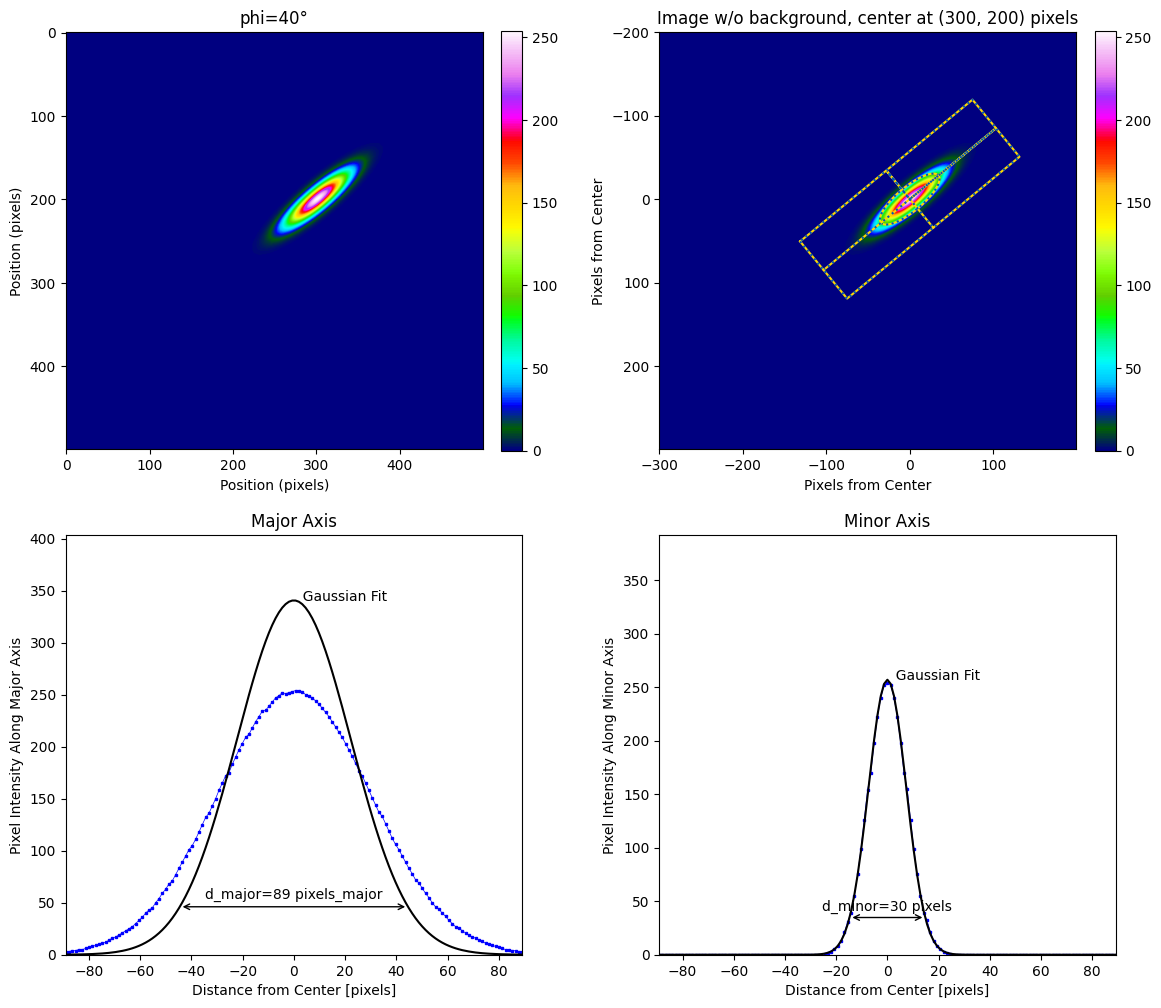

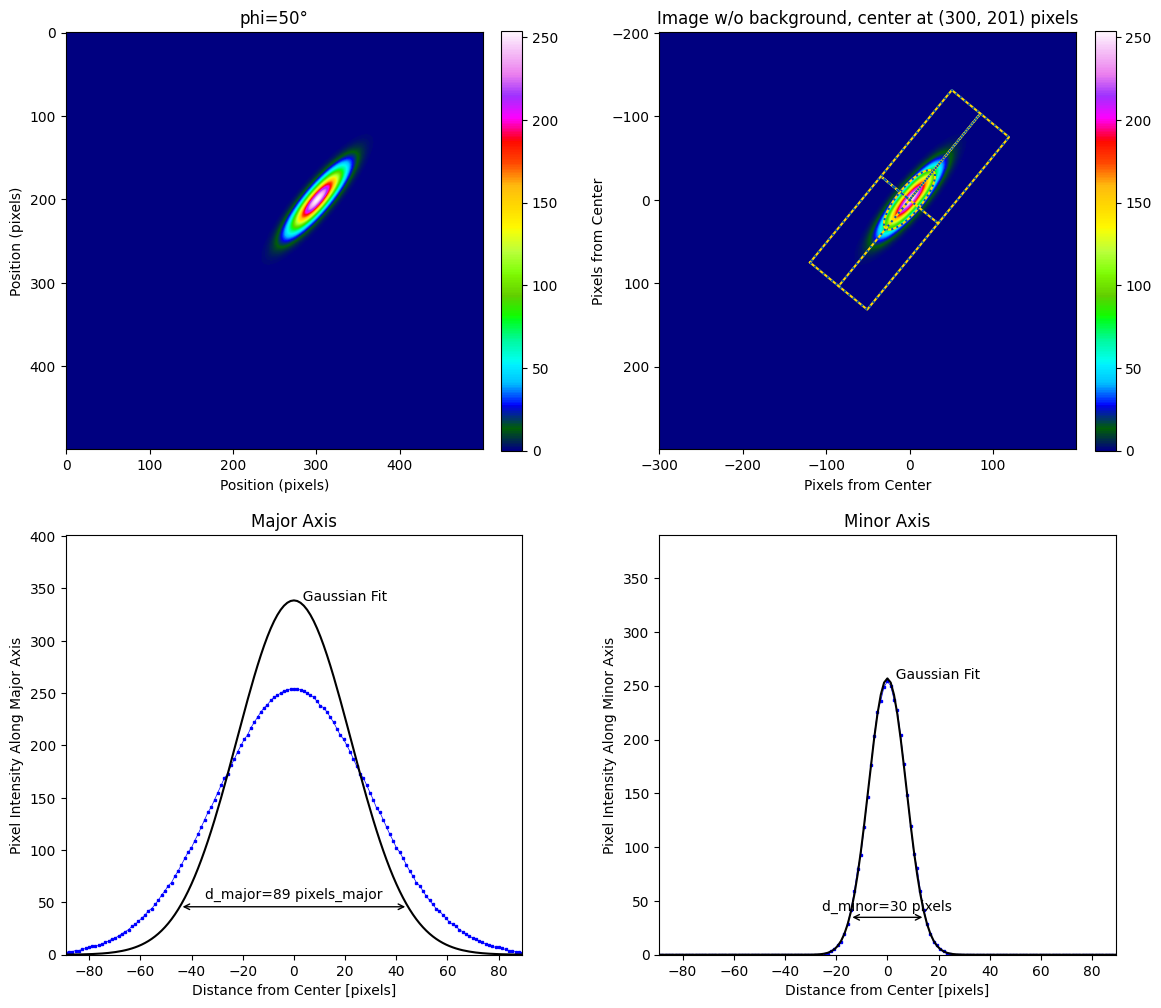

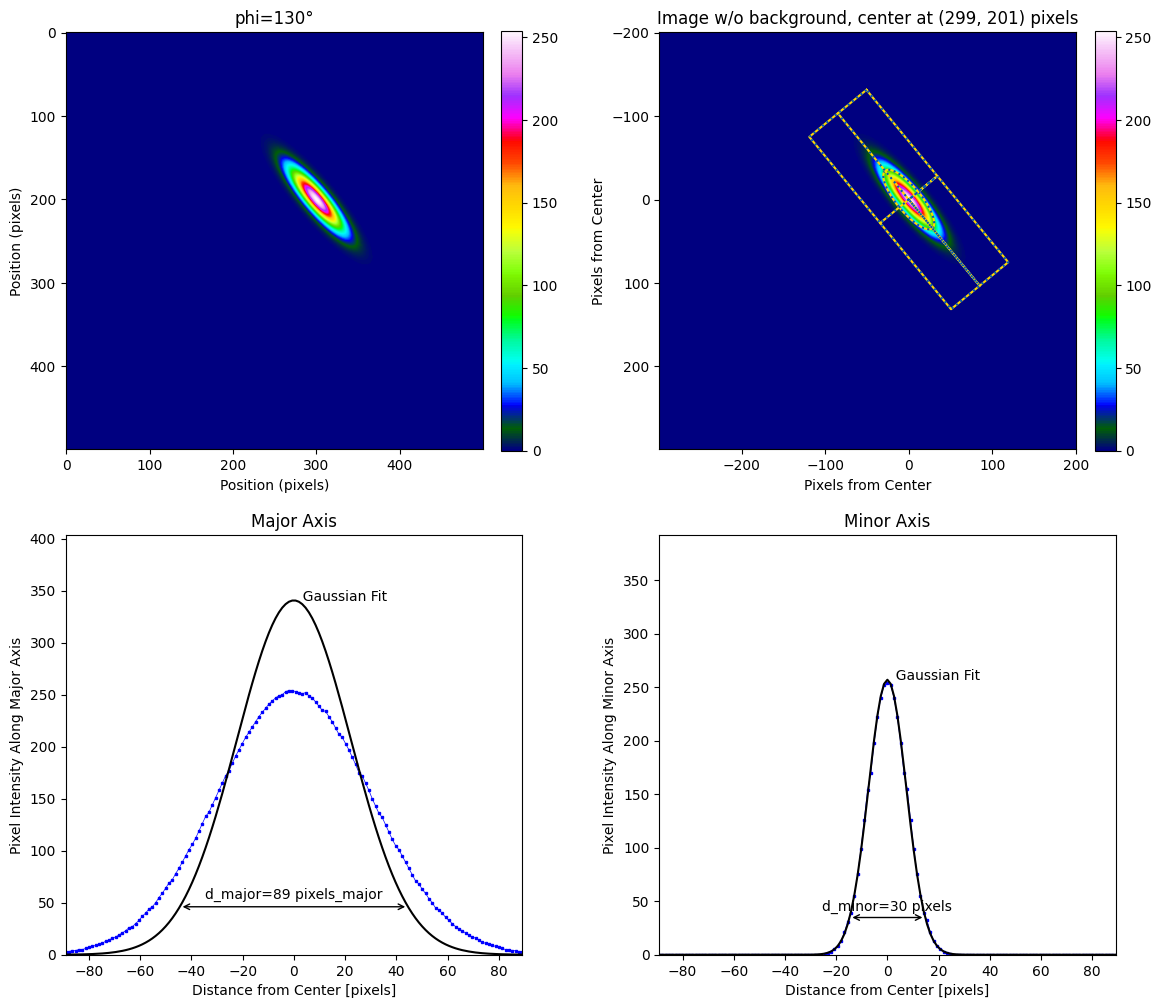

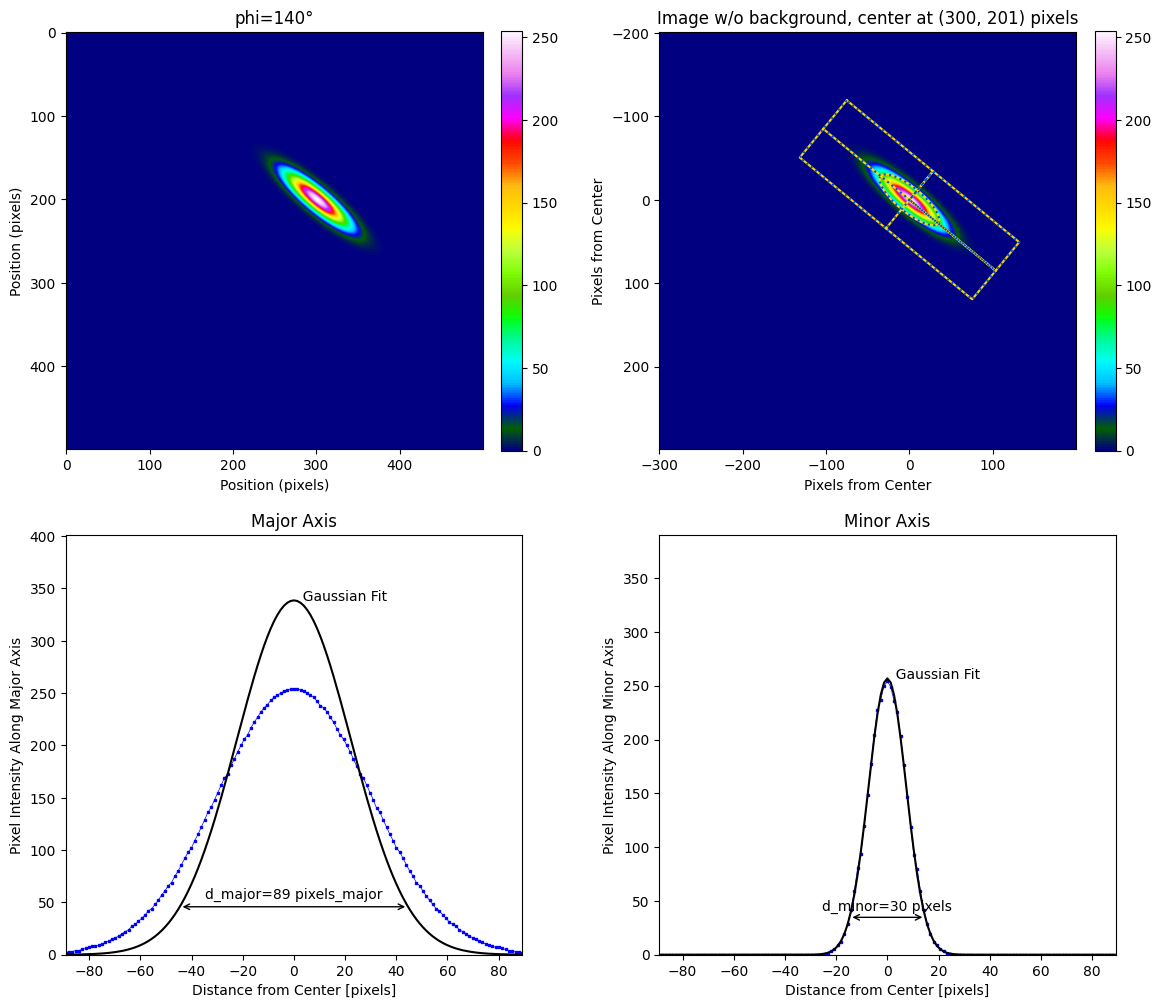

In [12]:
xc = 300
yc = 200
d_major = 120
d_minor = 30
h = 500
v = 500
max_value = 255
noise = 0.04 * max_value

# major axis changes at 45 and 135 degrees.  test on each side
for phi_degrees in [40, 50, 130, 140]:
    phi = np.radians(phi_degrees)
    test = lbs.create_test_image(h, v, xc, yc, d_major, d_minor, phi, max_value=max_value)
    title = "phi=%d°" % (phi_degrees)
    lbs.plot_image_analysis(test, title, iso_noise=True)
    plt.show()
    print("\n\n\n\n\n")